In [1]:
from rdkit import Chem
ref = "[CH3:1][C:2](=[O:3])[OH:4].[CH3:5][CH2:6][OH:7]>>[CH3:1][C:2](=[O:3])[O:7][CH2:6][CH3:5].[OH2:4]"
mapped = "[CH3:1][C:2](=[O:3])[OH:4].[CH3:5][CH2:6][OH:7]>>[CH3:1][C:2](=[O:4])[O:7][CH2:6][CH3:5].[OH2:3]" 

In [46]:
import io
import rdkit.Chem.rdmolfiles as rdmolfiles
import rdkit.Chem.Draw.rdMolDraw2D as rdMolDraw2D
import rdkit.Chem.rdChemReactions as rdChemReactions
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.backends.backend_pdf

from PIL import Image
from synrbl.SynUtils.chem_utils import remove_atom_mapping, normalize_smiles


class RxnVis:
    def __init__(
        self,
        nrows=1,
        ncols=1,
        dpi=400,
        figsize=(16, 9),
        cairosize=(1600, 900),
        border=10,
        show=True,
        remove_aam=False,
        normalize=False,
        close_fig=True,
    ):
        self.nrows = nrows
        self.ncols = ncols
        self.dpi = dpi
        self.figsize = figsize
        self.cairosize = cairosize
        self.border = border
        self.show = show
        self.remove_aam = remove_aam
        self.normalize = normalize
        self.close_fig = close_fig

    def get_rxn_img(self, smiles):
        drawer = rdMolDraw2D.MolDraw2DCairo(*self.cairosize)
        opts = drawer.drawOptions()
        opts.scale = 1
        opts.bondLineWidth = 5
        opts.atomLabelFontSize = (100)
        #opts.padding = 0.08
        if ">>" in smiles:
            rxn = rdChemReactions.ReactionFromSmarts(smiles, useSmiles=True)
            drawer.DrawReaction(rxn)
        else:
            mol = rdmolfiles.MolFromSmiles(smiles)
            if mol is None:
                mol = rdmolfiles.MolFromSmarts(smiles)
            drawer.DrawMolecule(mol)
        drawer.FinishDrawing()
        img = Image.open(io.BytesIO(drawer.GetDrawingText()))
        nonwhite_positions = [
            (x, y)
            for x in range(img.size[0])
            for y in range(img.size[1])
            if img.getdata()[x + y * img.size[0]] != (255, 255, 255)  # type: ignore
        ]
        rect = (
            min([x - self.border for x, y in nonwhite_positions]),
            min([y - self.border for x, y in nonwhite_positions]),
            max([x + self.border for x, y in nonwhite_positions]),
            max([y + self.border for x, y in nonwhite_positions]),
        )
        return img.crop(rect)

    def __parse_input(self, smiles, titles):
        if isinstance(smiles, str):
            smiles = [smiles]
        if titles is None:
            titles = [None for _ in range(len(smiles))]
        return smiles, titles

    def __get_fig(self):
        fig, axs = plt.subplots(
            self.nrows, self.ncols, dpi=self.dpi, figsize=self.figsize
        )
        if self.ncols * self.nrows == 1:
            axs = [[axs]]
        elif self.nrows == 1:
            axs = [axs]
        elif self.ncols == 1:
            axs = [[a] for a in axs]
        return fig, axs

    def __get_ax(self, axs, i, title=None):
        i_r = int(i / self.ncols)
        i_c = int(i % self.ncols)
        ax = axs[i_r][i_c]
        if title is not None:
            ax.set_title(title)
        ax.axis("off")
        return ax

    def plot(
        self,
        smiles: str | list[str],
        titles=None,
        savefig=None,
        show=None,
        remove_aam=None,
        normalize=None,
        close_fig=None,
    ):
        smiles, titles = self.__parse_input(smiles, titles)
        show = show if show is not None else self.show
        remove_aam = remove_aam if remove_aam is not None else self.remove_aam
        normalize = normalize if normalize is not None else self.normalize
        close_fig = close_fig if close_fig is not None else self.close_fig

        if normalize:
            smiles = [normalize_smiles(s) for s in smiles]
        elif remove_aam:
            smiles = [remove_atom_mapping(s) for s in smiles]

        fig, axs = self.__get_fig()
        for i, (s, t) in enumerate(zip(smiles, titles)):
            if i == self.nrows * self.ncols:
                print(
                    "[WARN] {} reactions will not be displayed.".format(len(smiles) - i)
                )
                break
            ax = self.__get_ax(axs, i, title=t)
            if s is not None and len(s) > 0:
                img = self.get_rxn_img(s)
                ax.imshow(img)
        #fig.tight_layout()
        if savefig is not None:
            fig.savefig(savefig)
        if show is True:
            plt.show()
        elif close_fig:
            plt.close(fig)
            fig = None
        return fig, axs



class Rxn2Pdf:
    def __init__(self, file, **kwargs):
        kwargs = Rxn2Pdf.__override_kwargs(**kwargs)
        self.rxnvis = RxnVis(**kwargs)
        self.pdf = matplotlib.backends.backend_pdf.PdfPages(file)

    @staticmethod
    def __override_kwargs(**kwargs):
        kwargs["close_fig"] = False
        kwargs["show"] = False
        return kwargs

    def add(self, smiles, **kwargs):
        if self.pdf is None:
            raise RuntimeError("Pdf is already closed.")
        kwargs = Rxn2Pdf.__override_kwargs(**kwargs)
        fig, _ = self.rxnvis.plot(smiles, **kwargs)
        self.pdf.savefig(fig)
        plt.close(fig)

    def close(self):
        if self.pdf is None:
            raise RuntimeError("Pdf is already closed.")
        self.pdf.close()
        self.pdf = None

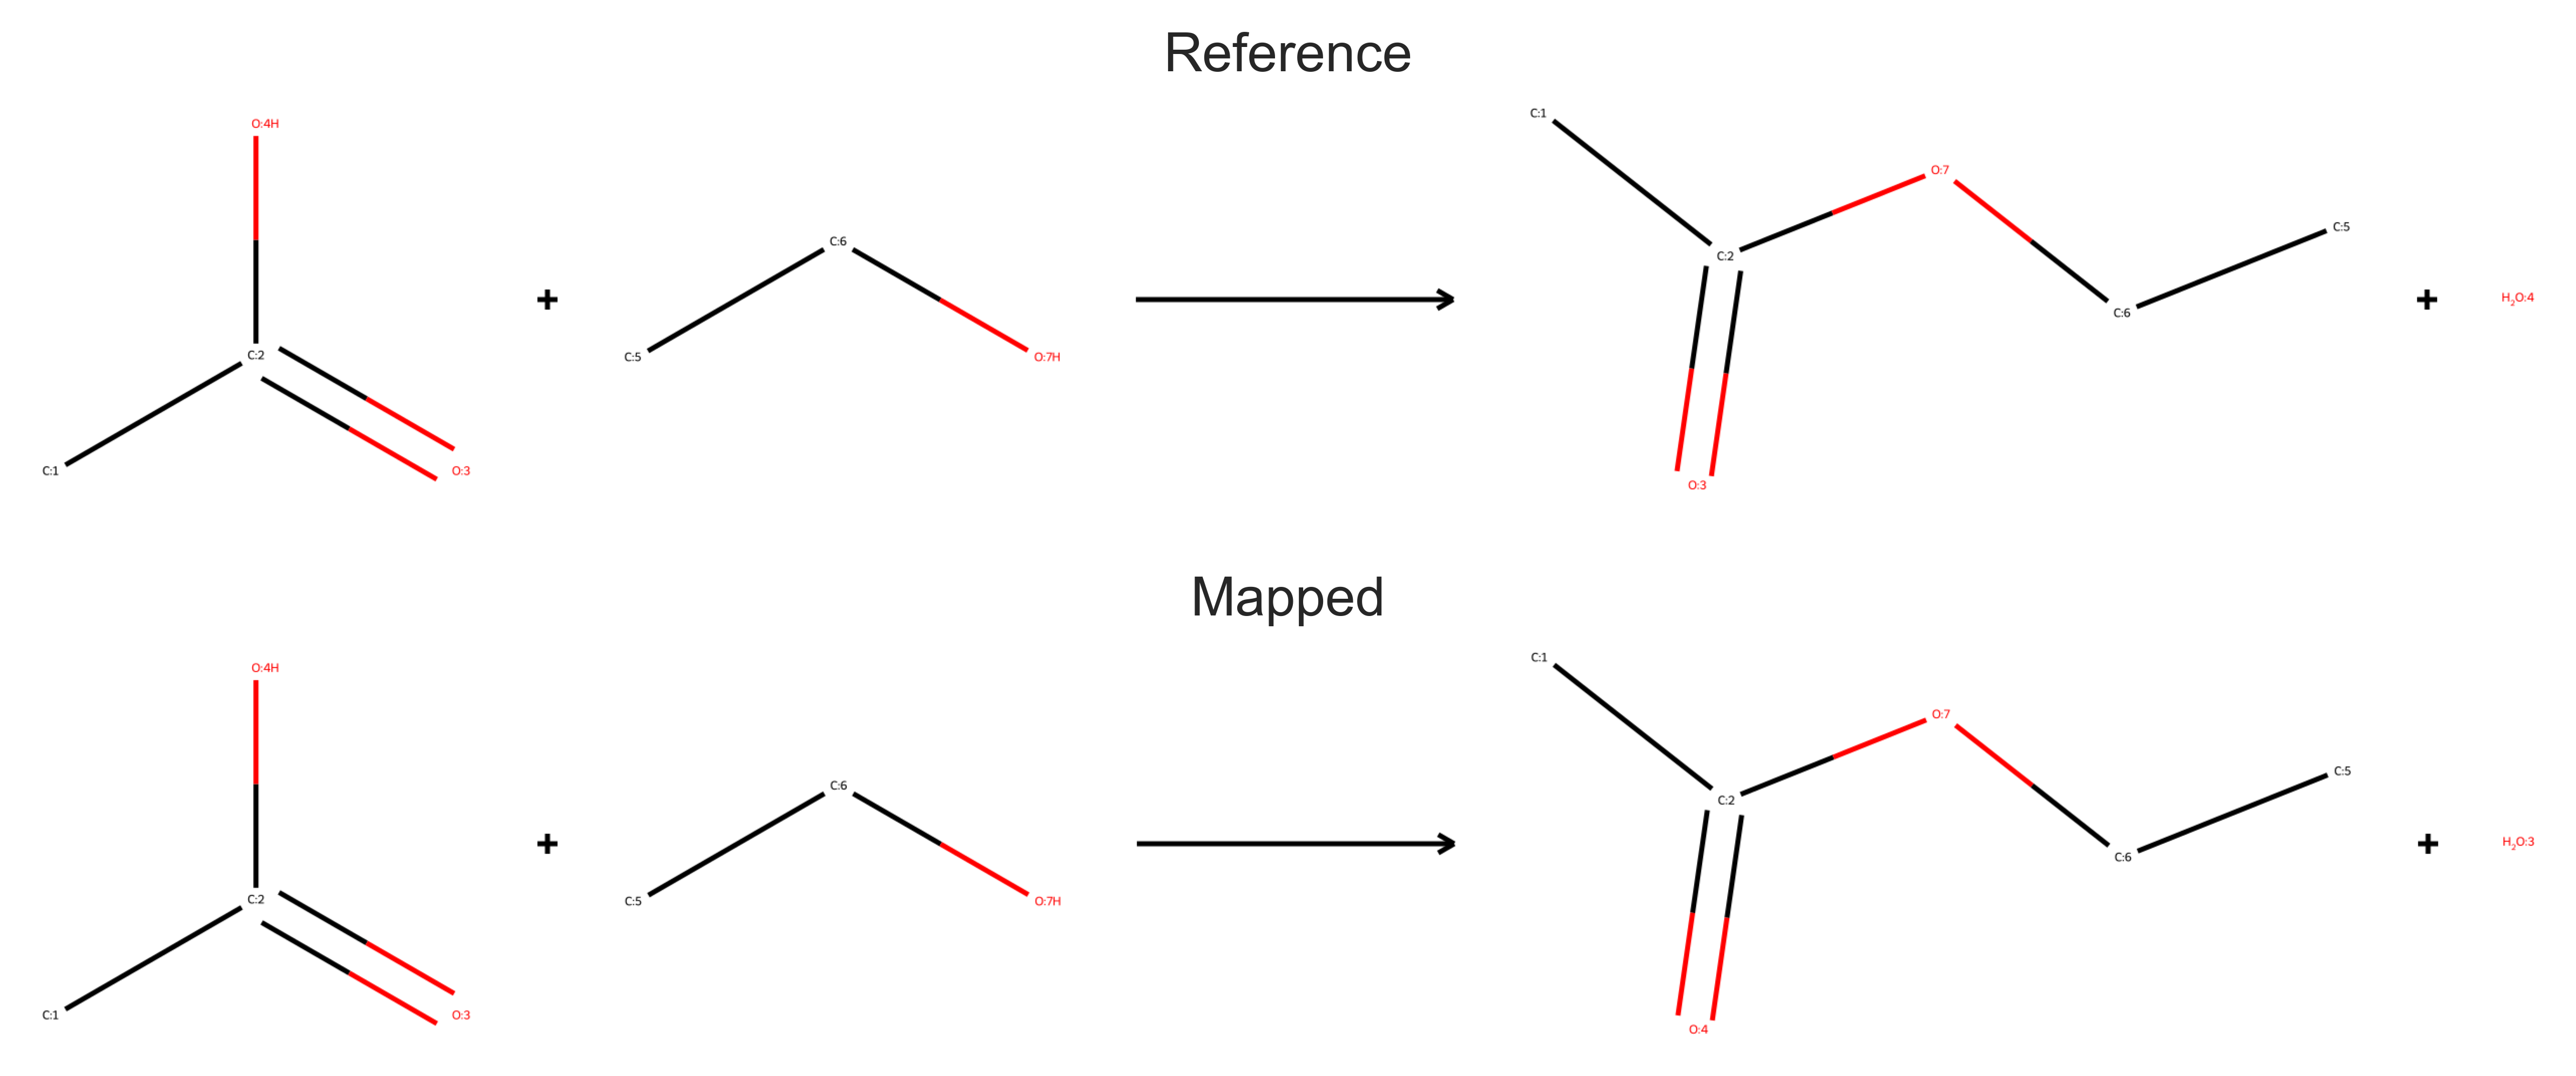

In [47]:
#from synrbl.SynVis.rxnvis import RxnVis
rxn_vis = RxnVis(nrows=2, ncols=1, cairosize=(3000, 2000), border=10, figsize=(10,4), dpi=600)
fig, _ = rxn_vis.plot([ref, mapped], ['Reference', 'Mapped'], savefig=None )

In [52]:
import io
import matplotlib.pyplot as plt

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import rdMolDraw2D
from PIL import Image
from typing import Dict, Tuple, Optional


class ReactionVisualizer:
    """
    Plot and optionally compare two chemical reactions for visualization using
    data from a given source.

    This method allows the visualization of chemical reactions represented as
    strings. It can plot a single reaction or compare two reactions
    side-by-side, depending on the 'compare' parameter. The reactions are
    visualized using RDKit and plotted using Matplotlib.

    Parameters
    ----------
    data : dict
        A dictionary containing the reaction data.
    old_reaction_col : str
        The key in 'data' for the old reaction string.
    new_reaction_col : str
        The key in 'data' for the new reaction string.
    compare : bool, optional
        If True, both the old and new reactions are plotted side by side for
        comparison. Default is False.
    orientation : str, optional
        The layout orientation of the plots, either 'vertical' or 'horizontal'.
        Default is 'vertical'.
    savefig : bool, optional
        If True, the figure is saved to the specified pathname. Default is False.
    pathname : str, optional
        The pathname where the figure will be saved, if 'savefig' is True.
    dpi : int, optional
        The resolution of the figure in dots per inch. Default is 300.

    Examples
    --------
    # Example usage of the plot_reactions method
    visualizer = ReactionVisualizer()
    reaction_data = {
        "old_reaction": "C1=CC=CC=C1.CCO>>C1=CC=CC=C1OCCO",
        "new_reaction": "C1=CC=CC=C1>>CCO",
    }
    visualizer.plot_reactions(
        reaction_data,
        "old_reaction",
        "new_reaction",
        compare=True,
        orientation="horizontal",
    )

    # To save the plot as an image
    visualizer.plot_reactions(
        reaction_data,
        "old_reaction",
        "new_reaction",
        compare=True,
        savefig=True,
        pathname="reaction_comparison.png",
    )
    """

    def __init__(
        self,
        compare: bool = True,
        orientation: str = "vertical",
        figsize: Tuple[int, int] = (10, 5),
        label_position: str = "below",
        dpi: int = 300,
        bond_line_width: float = 6,
        atom_label_font_size: int = 50,
        padding: float = 0.001,
    ) -> None:
        """
        Initialize the ReactionVisualizer.

        Parameters:
        - compare (bool): Whether to compare old and new reactions side by
            side. Default is True.
        - orientation (str): Orientation of comparison ('vertical' or
            'horizontal'). Default is 'vertical'.
        - figsize (Tuple[int, int]): Figure size (width, height) in inches.
            Default is (10, 5).
        - label_position (str): Position of labels ('above' or 'below') the
            reaction images. Default is 'below'.
        - dpi (int): Dots per inch for image resolution. Default is 300.
        - bond_line_width (float): Width of bond lines in the reaction image.
            Default is 6.
        - atom_label_font_size (int): Font size for atom labels in the reaction
            image. Default is 50.
        - padding (float): Padding around the drawing in the reaction image.
            Default is 0.001.
        """
        self.compare = compare
        self.orientation = orientation
        self.figsize = figsize
        self.label_position = label_position
        self.dpi = dpi
        self.bond_line_width = bond_line_width
        self.atom_label_font_size = atom_label_font_size
        self.padding = padding

    @staticmethod
    def draw_molecule_with_atom_numbers(mol):
        """
        Draw a molecule with atom numbers annotated.

        Parameters
        ----------
        mol : RDKit Molecule object
            The molecule to be drawn with atom numbers.

        Returns
        -------
        mol : RDKit Molecule object
            The molecule with atom numbers.
        """
        mol_with_atom_numbers = Chem.Mol(mol)
        for atom in mol_with_atom_numbers.GetAtoms():
            atom.SetProp("atomLabel", str(atom.GetIdx()))
        return mol_with_atom_numbers

    def visualize_reaction(
        self, reaction_str: str, show_atom_numbers: bool = False
    ) -> Image:
        """
        Visualize a single chemical reaction and return the image.

        Parameters
        ----------
        reaction_str : str
            A string representation of the reaction (e.g., 'C1=CC=CC=C1>>CCO').

        Returns
        -------
        PIL.Image.Image
            An image of the chemical reaction.
        """
        # Parse reactants and products from the reaction string
        reactants_str, products_str = reaction_str.split(">>")
        reactants = [Chem.MolFromSmiles(smiles) for smiles in reactants_str.split(".")]
        products = [Chem.MolFromSmiles(smiles) for smiles in products_str.split(".")]

        if show_atom_numbers:
            reactants = [self.draw_molecule_with_atom_numbers(mol) for mol in reactants]
            products = [self.draw_molecule_with_atom_numbers(mol) for mol in products]

        rxn = AllChem.ChemicalReaction()
        for reactant in reactants:
            rxn.AddReactantTemplate(reactant)
        for product in products:
            rxn.AddProductTemplate(product)

        # Set up RDKit drawer with customizable parameters
        drawer = rdMolDraw2D.MolDraw2DCairo(2000, 600)  # Adjust canvas size as needed
        opts = drawer.drawOptions()
        opts.bondLineWidth = self.bond_line_width  # Increase bond line width
        opts.atomLabelFontSize = (
            self.atom_label_font_size
        )  # Increase font size for atom labels
        opts.padding = self.padding  # Adjust padding around the drawing

        drawer.DrawReaction(rxn)
        drawer.FinishDrawing()
        return Image.open(io.BytesIO(drawer.GetDrawingText()))

    def plot_reactions(
        self,
        data: Dict[str, str],
        old_reaction_col: str,
        new_reaction_col: str,
        compare: bool = False,
        orientation: str = "vertical",
        savefig: bool = False,
        pathname: Optional[str] = None,
        dpi: int = 300,
        show_atom_numbers: bool = False,
    ) -> None:
        """
        Plot one or two chemical reactions for visualization.

        Parameters
        ----------
        data : Dict[str, str]
            A dictionary containing the data with keys as column names and
            values as reaction strings.
        old_reaction_col : str
            The column name containing the string representation of the old reaction.
        new_reaction_col : str
            The column name containing the string representation of the new reaction.
        compare : bool, optional
            If True, both the old and new reactions are plotted. Default is False.
        orientation : str, optional
            The layout orientation of the plots ('vertical' or 'horizontal').
            Default is 'vertical'.
        savefig : bool, optional
            If True, saves the figure to the specified pathname. Default is False.
        pathname : str, optional
            Pathname to save the figure, if savefig is True.
        dpi : int, optional
            Resolution of the figure in dots per inch. Default is 300.
        """
        # Get the old and new reaction strings from the data
        old_reaction_str = data[old_reaction_col]
        new_reaction_str = data[new_reaction_col]

        # Create reaction images
        new_reaction_image = self.visualize_reaction(
            new_reaction_str, show_atom_numbers
        )
        old_reaction_image = (
            self.visualize_reaction(old_reaction_str, show_atom_numbers)
            if compare
            else None
        )

        # Set up plot layout
        if compare:
            nrows, ncols = (2, 1) if orientation == "vertical" else (1, 2)
            fig, axs = plt.subplots(nrows, ncols, figsize=self.figsize, dpi=dpi)
            ax_new = axs[1] if orientation == "vertical" else axs[0]
            ax_old = axs[0] if orientation == "vertical" else axs[1]
        else:
            fig, ax = plt.subplots(figsize=self.figsize, dpi=dpi)

        # Plotting logic
        if compare:
            ax_old.imshow(old_reaction_image)
            ax_old.axis("off")
            ax_new.imshow(new_reaction_image)
            ax_new.axis("off")
        else:
            ax.imshow(new_reaction_image)
            ax.axis("off")

        # Setting titles
        label_y_position = -0.1 if self.label_position == "below" else 1.1
        if compare:
            ax_old.set_title(
                "Reference", position=(0.5, label_y_position), weight="bold"
            )
            ax_new.set_title(
                "Mapped", position=(0.5, label_y_position), weight="bold"
            )
        else:
            ax.set_title(
                "New Reaction", position=(0.5, label_y_position), weight="bold"
            )

        # Saving the figure
        if savefig and pathname:
            fig.savefig(pathname, dpi=dpi)

        # plt.tight_layout()
        return fig

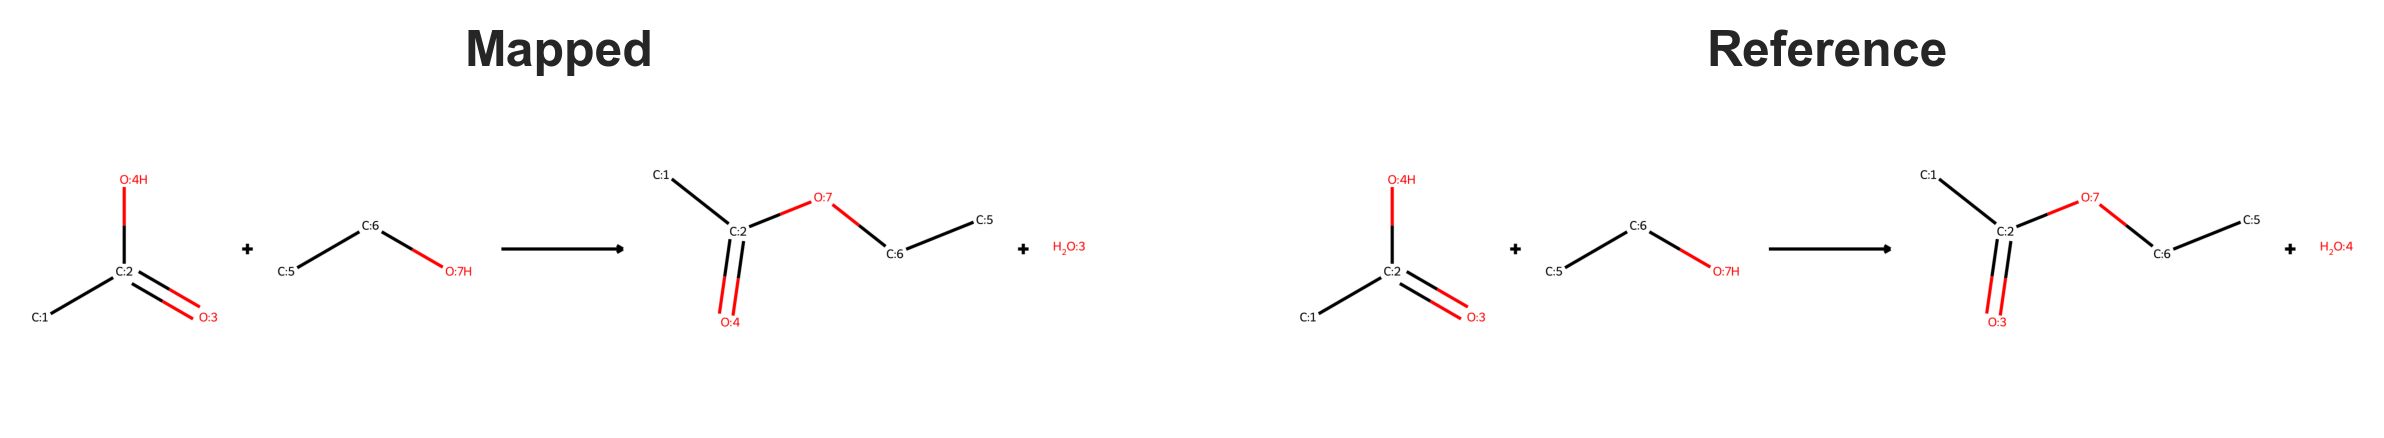

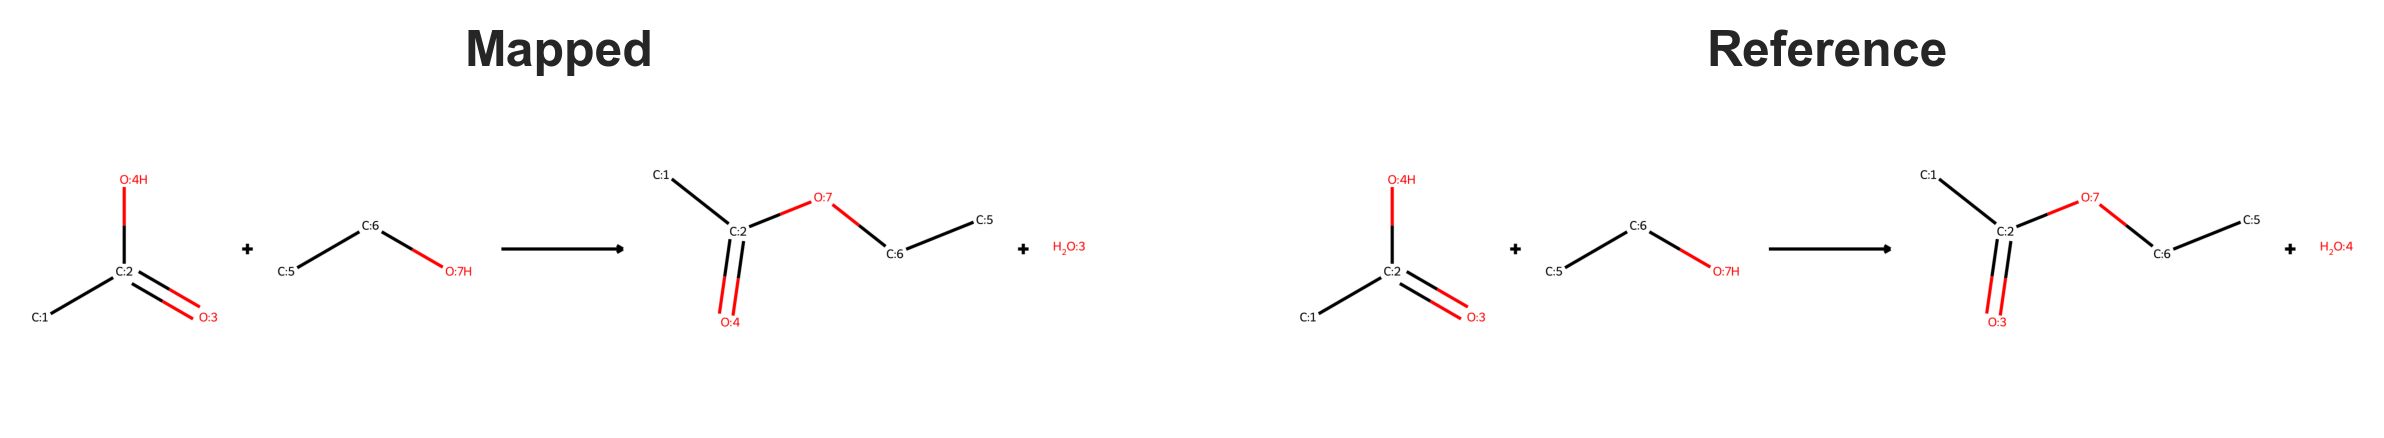

In [54]:
vis = ReactionVisualizer()
vis.plot_reactions(toy_sample[0], 'reference', 'mapper', compare=True, orientation='horizontal', savefig=True,pathname='./Fig/tautomer_issue.pdf',
                    dpi=600)

In [21]:
import sys
sys.path.append('../../')
from SynTemp.SynITS.its_extraction import ITSExtraction
toy_sample = [{'balanced': True,
  'R-id': '0',
  'reference': "[CH3:1][C:2](=[O:3])[OH:4].[CH3:5][CH2:6][OH:7]>>[CH3:1][C:2](=[O:3])[O:7][CH2:6][CH3:5].[OH2:4]",
  'mapper': "[CH3:1][C:2](=[O:3])[OH:4].[CH3:5][CH2:6][OH:7]>>[CH3:1][C:2](=[O:4])[O:7][CH2:6][CH3:5].[OH2:3]",
  'Valid': True}]

mapper_name = ['reference', 'mapper']
its_graph, its_graph_wrong = ITSExtraction.parallel_process_smiles(toy_sample, mapper_name, threshold=1, n_jobs=1, verbose=1, export_full=True, check_method='RC')

In [22]:
its_graph_wrong

[{'R-id': '0',
  'reference': (<networkx.classes.graph.Graph at 0x16a22ff90>,
   <networkx.classes.graph.Graph at 0x16a24ca50>),
  'mapper': (<networkx.classes.graph.Graph at 0x16a24d7d0>,
   <networkx.classes.graph.Graph at 0x16a23ad90>),
  'equivariant': 0,
  'ITSGraph': (<networkx.classes.graph.Graph at 0x14fd9f910>,
   <networkx.classes.graph.Graph at 0x14fa68cd0>),
  'GraphRules': (<networkx.classes.graph.Graph at 0x14fda0f90>,
   <networkx.classes.graph.Graph at 0x16a238390>)}]

In [23]:
its_graph_wrong[0]['reference']

(<networkx.classes.graph.Graph at 0x16a22ff90>,
 <networkx.classes.graph.Graph at 0x16a24ca50>)

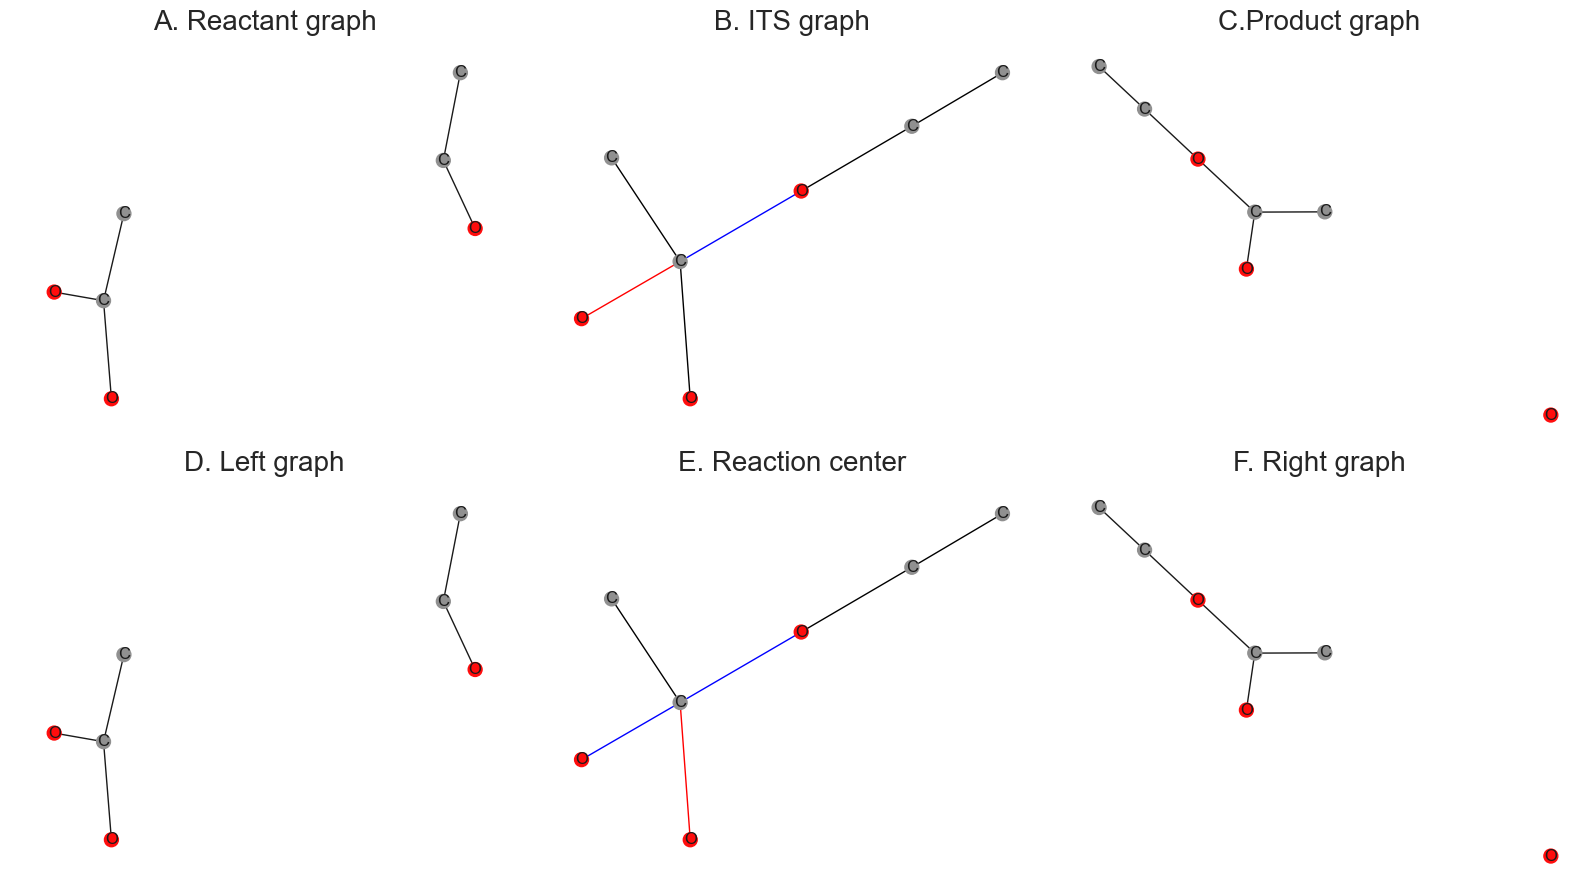

In [24]:
from SynTemp.SynVis.chemical_graph_visualizer import ChemicalGraphVisualizer
vis = ChemicalGraphVisualizer(seed=42)
vis.visualize_all(its_graph_wrong[0]['reference'], its_graph_wrong[0]['mapper'], save_path=None, titles_row1 =['A. Reactant graph', 'B. ITS graph', 'C.Product graph'], titles_row2=['D. Left graph', 'E. Reaction center', 'F. Right graph'], title_weight='medium', title_fontsize=20, figsize=(16,9))